In [ ]:
import json
import cv2
import os
import multiprocessing as mp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dl.utils.io_utils import normalize_image

%matplotlib inline
from cv.core.image_quality_server_side import ImageQuality

# from cv.core.image_quality_server_side_halo import ImageQuality
from dl.utils.config import DEFAULT_TONEMAP_PARAMS
import tqdm
from dl.utils.mask_utils import get_mask
from cv.core.image_quality_schema import (
    Bad_Depth,
    Bright,
    Dark,
    ImageQualityClasses,
    ImageQualityFeatures,
    ImageQualityParameters,
    Smudge,
)



In [ ]:
# Please update the default location as you deem fit
cvml_path = '/home/alex.li/git/JupiterCVML/europa/base/src/europa'
halo_mask_dir = cvml_path + "/dl/config/halo_masks"
dataset_idx = 0
directory = ['/data/jupiter/datasets/bad_iq_halo_labelbox_plus_exposure', '/data2/jupiter/datasets/20231017_halo_rgb_labeled_excluded_bad_iq', '/data/jupiter/datasets/iq_2023_v5_anno'][dataset_idx]
csv_name = ['654a5bb2e89875bddc714dd2_master_annotations.csv', '653a7a0a3c2d8ab221f6d915_master_annotations.csv','64dfcc1de5a41169c7deb205_master_annotations.csv'][dataset_idx]

dset_name = directory.split('/')[-1]
stereo_df_full = pd.read_csv(os.path.join(directory, csv_name), low_memory=False)
df = stereo_df_full.drop_duplicates(['id'])[:10000]

In [ ]:
halo_masks = {}
for file in os.listdir(halo_mask_dir):
    if not file.endswith(".png"):
        continue
    name = file.split("_")[0] + "_" + file.split("_")[1]
    halo_masks[name] = get_mask(os.path.join(halo_mask_dir, file))
def mask_image(image, camera_location):
    mask_name = camera_location + "_" + str(image.shape[1])
    if mask_name in halo_masks.keys():
        return halo_masks[mask_name]
    return np.zeros_like(image, dtype=np.uint8)[:,:,0]

In [ ]:
file_name = os.listdir(folder_path)[0]
obj = np.load(folder_path + file_name)
im_l = normalize_image(obj['left'], row['hdr_mode']) * 255
depth = obj['point_cloud'][..., 2]
sky_mask = np.zeros_like(depth, dtype=np.uint8)
sky_mask[depth > 50] = 1
sky_mask = cv2.resize(sky_mask, (im_l.shape[1], im_l.shape[0]))
ego_mask = mask_image(im_l, row['camera_location'])
mask = sky_mask | ego_mask
left_gray_img = np.int32(cv2.cvtColor(im_l, cv2.COLOR_RGB2GRAY))
left_hsl_img = np.int32(cv2.cvtColor(im_l, code=cv2.COLOR_RGB2HSV)[:,:,2])

In [383]:
# IQ parameteres
def get_image_and_mask(row):
    folder_path  = directory + "/processed/images/" + row['id'] + "/"
    file_name = os.listdir(folder_path)[0]
    obj = np.load(folder_path + file_name)
    im_l = normalize_image(obj['left'], row['hdr_mode'], return_8_bit=True)
    im_r = normalize_image(obj['right'], row['hdr_mode'], return_8_bit=True)
    depth = obj['point_cloud'][..., 2]
    sky_mask = np.zeros_like(depth, dtype=np.uint8)
    sky_mask[depth > 50] = 1
    sky_mask[im_l.shape[0]//2:,:] = 0 # bottom should never be sky no matter what the depth says
    sky_mask = cv2.resize(sky_mask, (im_l.shape[1], im_l.shape[0]))
    ego_mask = mask_image(im_l, row['camera_location'])
    mask = (1 - sky_mask | ego_mask)
    return {
        'im_l_hdr': obj['left'],
        'im_l': im_l,
        'im_r': im_r,
        'mask': mask
    }
def get_binary_image(gray_img, row):
    binary_image = cv2.medianBlur(gray_img, Smudge.BINARY_KERNEL_SIZE)
    if row['operation_time'] == "daytime":
        gray_scale_min_pix_diff_threshold = 45
        gray_scale_max_pix_diff_threshold = 88
        threshold_type = cv2.THRESH_BINARY
    else:
        gray_scale_min_pix_diff_threshold = 60
        gray_scale_max_pix_diff_threshold = 98
        threshold_type = cv2.THRESH_BINARY_INV

    binary_image = cv2.adaptiveThreshold(
        binary_image,
        ImageQualityParameters.MAX_RANGE,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        threshold_type,
        Smudge.BINARY_KERNEL_SIZE,
        2,
        )
    return binary_image

def diff_in_grid(img_l: np.ndarray, img_r: np.ndarray) -> np.ndarray:
    """Stats on every DEFAULT_GRID_SIZE x DEFAULT_GRID_SIZE square of the l/r image pair"""
    l_cum = np.cumsum(np.cumsum(img_l, axis=1, dtype=np.int32), axis=0)
    r_cum = np.cumsum(np.cumsum(img_r, axis=1, dtype=np.int32), axis=0)
    S = 128 #DEFAULT_GRID_SIZE
    # left_sum[i,j] = np.sum(img_l[i:i+S,j:j+S])
    left_sum = l_cum[128:,128:] + l_cum[:-128,:-128] - l_cum[128:,:-128] - l_cum[:-128,128:]
    right_sum = r_cum[128:,128:] + r_cum[:-128,:-128] - r_cum[128:,:-128] - r_cum[:-128,128:]
    diff_grid = abs(left_sum - right_sum) // (S * S)
    return diff_grid

In [396]:
USE_SAVED = False
if USE_SAVED:
    sub_df = pd.read_parquet('~/logs/iq_analysis.parquet')
else:
    sub_df = df.copy()[1::10]
    brightness_gray_at_p = []
    brightness_hdr_at_p = []
    brightness_hdr_lo_at_p = []
    grayscale_max_diff = []
    binary_max_diff = []
    adaptive_thresh_max_cc = []
    for i in range(100):
        brightness_gray_at_p.append([])
        brightness_hdr_at_p.append([])
        brightness_hdr_lo_at_p.append([])
    for _, row in tqdm.tqdm(iterable=sub_df.iterrows(), total=len(sub_df)):
        res  = get_image_and_mask(row)
        im_l_hdr = res['im_l_hdr']
        im_l = res['im_l']
        im_r = res['im_r']
        mask = res['mask']
        left_gray_img = cv2.cvtColor(im_l, cv2.COLOR_RGB2GRAY)

        # BRIGHTNESS
        # for i, val in enumerate(iterable=list(np.percentile(left_gray_img[mask], range(100)))):
        #     brightness_gray_at_p[i].append(val)
        # hdr_gray = im_l_hdr[:,:,0] * .2126 + im_l_hdr[:,:,1] * .7152 + im_l_hdr[:,:,2] * .0722
        # for i, val in enumerate(iterable=list(np.percentile(hdr_gray[mask], range(100)))):
        #     brightness_hdr_at_p[i].append(val)

        ## SMUDGE
        # Grayscale difference
        right_gray_img = cv2.cvtColor(im_r, cv2.COLOR_RGB2GRAY)
        diff_grid = diff_in_grid(left_gray_img * mask, right_gray_img * mask)

        # Binary difference
        left_binary_img = get_binary_image(left_gray_img, row)
        right_binary_img = get_binary_image(right_gray_img, row)
        binary_diff_grid = diff_in_grid(left_binary_img * mask, right_binary_img * mask)
        grayscale_max_diff.append(np.max(diff_grid))
        binary_max_diff.append(np.max(binary_diff_grid))

        # # Adaptive threshold
        left_binary_img_adaptive = np.logical_and(left_binary_img, mask)
        kernel = np.ones(
            (
                Smudge.ADAPTIVE_THRESHOLD_KERNEL_SIZE,
                Smudge.ADAPTIVE_THRESHOLD_KERNEL_SIZE,
            ),
            np.uint8,
        )
        left_binary_img_adaptive = cv2.erode(left_binary_img_adaptive.astype(np.uint8), kernel)
        left_binary_img_adaptive = cv2.medianBlur(
            left_binary_img_adaptive, Smudge.ADAPTIVE_THRESHOLD_BLUR_KERNEL_SIZE
        )
        totalLabels, _, values, _ = cv2.connectedComponentsWithStats(
            left_binary_img_adaptive, Smudge.CONNECTIVITY_WAY, cv2.CV_32S
        )
        smudge_areas = []
        # Loop through each component
        for j in range(1, totalLabels):
            # Area of the component
            smudge_areas.append(values[j, cv2.CC_STAT_AREA])
        smudge_areas = [a for a in smudge_areas if a < Smudge.CONNECTED_COMPONENTS_MAX_AREA]
        biggest_smudge = max(smudge_areas +[0])
        adaptive_thresh_max_cc.append(biggest_smudge)

    # for i in range(100):
    #     sub_df[f'gray_{i}'] = brightness_gray_at_p[i]
    #     sub_df[f'hdr_{i}'] = brightness_hdr_at_p[i]
    sub_df['gray_diff'] = grayscale_max_diff
    sub_df['binary_diff'] = binary_max_diff
    sub_df['adaptive'] = adaptive_thresh_max_cc
    
    sub_df = sub_df.copy()
    sub_df.to_parquet('~/logs/iq_analysis.parquet')


  0%|          | 1/954 [00:00<02:40,  5.95it/s]

100%|██████████| 954/954 [02:15<00:00,  7.05it/s]


In [206]:
def show_images(cats, bright_quantity, percentile):
    ncols = 20
    cols_per_row = 5
    rows_per_cat = (cols_per_row - 1 + ncols) // cols_per_row
    nrows = len(cats) * rows_per_cat
    fig, ax = plt.subplots(nrows, cols_per_row, figsize=(cols_per_row * 3.2, nrows * 4))
    for i, subdf in enumerate(cats):
        for j in range(ncols):
            if j >= len(subdf):
                break
            folder_path  = directory + "/processed/images/" + subdf.iloc[j]['id'] + "/"
            file_name = os.listdir(folder_path)[0]
            obj = np.load(folder_path + file_name)
            im = normalize_image(obj['left'], subdf.iloc[j]['hdr_mode'])
            ax[i * rows_per_cat + j // cols_per_row][j % cols_per_row].imshow(im)
            ax[i * rows_per_cat + j // cols_per_row][j % cols_per_row].set_title(f"{bright_quantity}@{percentile}%:{subdf.iloc[j][f'{bright_quantity}_{percentile}']:.2}")
            ax[i * rows_per_cat + j // cols_per_row][j % cols_per_row].set_title(
                f"{subdf.iloc[j]['hdr_12']:.2f}g{int(subdf.iloc[j]['gray_70'])}g{int(subdf.iloc[j]['gray_20'])}w{subdf.iloc[j]['w']:.2f}")

In [393]:
SHOW_BRIGHT = False
if SHOW_BRIGHT:
    # is_bright = (sub_df['hdr_10'] > 1.2e4) & (sub_df['hdrlo_55'] > 1e4) & (sub_df['gray_70'] > 180) & (sub_df['gray_20'] > 75)
    w = sub_df['hdr_12'] / 1000 + np.maximum(sub_df['gray_70'] - 170, 0) + np.maximum(sub_df['gray_20'] - 75, 0) / 2
    w[sub_df['hdr_80'] < 1000] -= 100
    sub_df['w'] = w
    is_bright = w > 75
    bright_images = sub_df[is_bright]
    sub_df = sub_df.sort_values('w')
    show_images([sub_df[is_bright], sub_df[~is_bright][::-1]], 'hdr', 50)

In [410]:
def plot_image_smudge(df):
    assert len(df) <= 10
    nrows = len(df)
    cols_per_row = 6
    fig, ax = plt.subplots(nrows, cols_per_row, figsize=(cols_per_row * 3.2, nrows * 4))
    for i, (_, row) in enumerate(df.iterrows()):
        artifacts = get_image_and_mask(row)
        mask = artifacts['mask']
        ax[i][0].imshow(artifacts['im_l'] / 255)
        ax[i][1].imshow(artifacts['im_r'] / 255)

        # Grayscale difference
        left_gray_img = cv2.cvtColor(artifacts['im_l'], cv2.COLOR_RGB2GRAY)
        right_gray_img = cv2.cvtColor(artifacts['im_r'], cv2.COLOR_RGB2GRAY)
        diff_grid = diff_in_grid(left_gray_img * mask, right_gray_img * mask)

        # Binary difference
        left_binary_img = get_binary_image(left_gray_img, row)
        right_binary_img = get_binary_image(right_gray_img, row)
        binary_diff_grid = diff_in_grid(left_binary_img, right_binary_img)

        # Adaptive threshold
        left_binary_img_adaptive = np.logical_and(left_binary_img, mask)
        kernel = np.ones(
            (
                Smudge.ADAPTIVE_THRESHOLD_KERNEL_SIZE,
                Smudge.ADAPTIVE_THRESHOLD_KERNEL_SIZE,
            ),
            np.uint8,
        )
        left_binary_img_adaptive = cv2.erode(left_binary_img_adaptive.astype(np.uint8), kernel)
        left_binary_img_adaptive = cv2.medianBlur(
            left_binary_img_adaptive, Smudge.ADAPTIVE_THRESHOLD_BLUR_KERNEL_SIZE
        )
        totalLabels, _, values, _ = cv2.connectedComponentsWithStats(
            left_binary_img_adaptive, Smudge.CONNECTIVITY_WAY, cv2.CV_32S
        )
        smudge_areas = []
        # Loop through each component
        for j in range(1, totalLabels):
            # Area of the component
            smudge_areas.append(values[j, cv2.CC_STAT_AREA])
        smudge_areas = sorted(smudge_areas)[-5:]

        ax[i][2].imshow(diff_grid)
        ax[i][2].set_title(np.max(diff_grid))
        ax[i][3].imshow(binary_diff_grid)
        ax[i][3].set_title(np.max(binary_diff_grid))
        ax[i][4].imshow(left_binary_img_adaptive)
        ax[i][4].set_title(smudge_areas)
        ax[i][5].imshow(mask)
        ax[i][5].set_title("sky_mask | ego_mask")


/tmp/ipykernel_207956/1377019078.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unbright_df = sub_df[~is_bright]
/tmp/ipykernel_207956/1377019078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unbright_df['high_thresh'] = np.where(unbright_df['operation_time'] == 'daytime', 98, 108)
/tmp/ipykernel_207956/1377019078.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unbright_df['lo_thresh'] = np.where(unbright_df['operation_time'] == 'daytime', 55, 65)


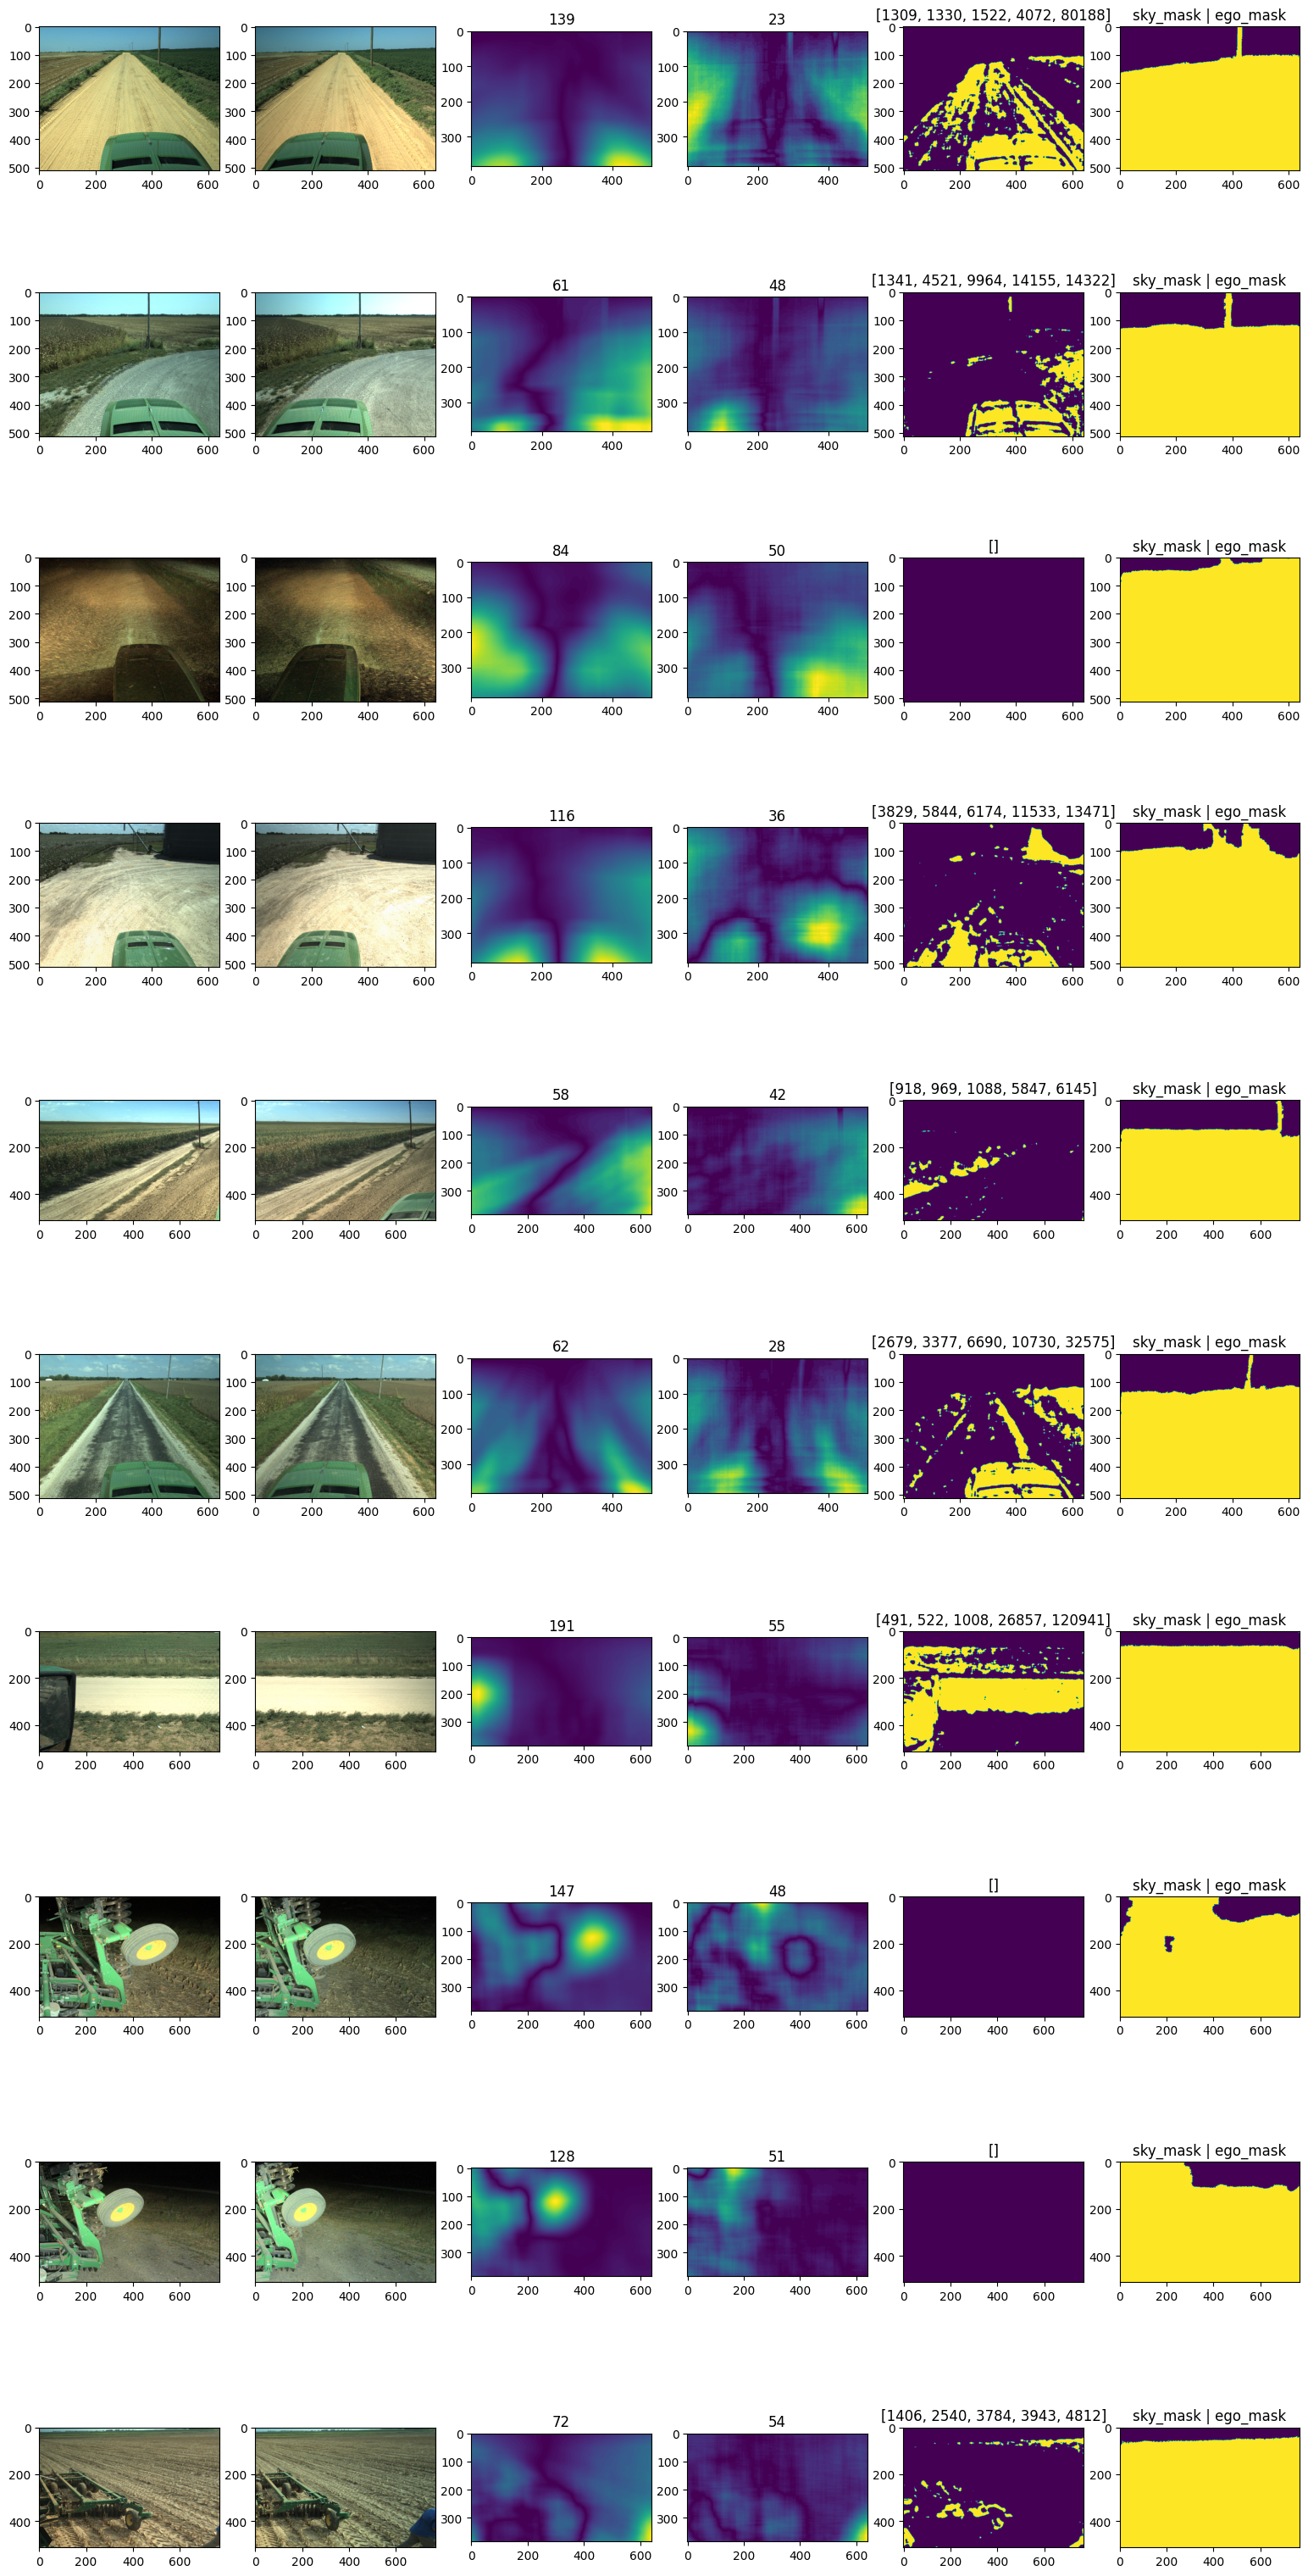

In [416]:
unbright_df = sub_df[~is_bright].copy()
unbright_df['high_thresh'] = np.where(unbright_df['operation_time'] == 'daytime', 98, 108)
unbright_df['lo_thresh'] = np.where(unbright_df['operation_time'] == 'daytime', 55, 65)
has_smudge = unbright_df['gray_diff'] > unbright_df['high_thresh']
no_smudge = unbright_df['gray_diff'] < unbright_df['lo_thresh']
has_smudge = has_smudge | (~no_smudge & (unbright_df['binary_diff'] > Smudge.BINARY_SMUDGE_THRESHOLD))
no_smudge = no_smudge | (unbright_df['binary_diff'] < Smudge.BINARY_NOT_A_SMUDGE_THRESHOLD)
has_smudge = has_smudge | (~no_smudge & (unbright_df['adaptive'] > Smudge.CONNECTED_COMPONENTS_MIN_AREA))

plot_image_smudge(unbright_df[has_smudge][:10])

In [171]:
plot_image(sub_df[~is_bright][-50:-40])